Collin Rinehart \newline
ASEN6010 Homework 2

## Problem 2
Develop a numerical simulation where you integrate the equations of motion of a rigid
spacecraft containing N VSCMGs. Write the code general enough where you can easily run RW- or
CMG-only cases. Also, the gimbal frame of each VSCMG should be generic in the code and easily
changeable. To prove that the simulation works properly, illustrate a case where the total energy is
conserved, and illustrate a case where the RW and CMG torques are applied. Compare the numerically
computed system energy rate/power versus the analytically derived power equation.


# Function Definitions

In [32]:
import math
import matplotlib.pyplot as plt
import numpy as np

def tilde(vec):
    #  Uses Numpy array column vectors to define a tilde matrix
    #  Returns a 3x3 NumPy array
    vec_tilde = np.array([[0, -float(vec[2]), float(vec[1])],
                           [float(vec[2]), 0, -float(vec[0])],
                           [-float(vec[1]), float(vec[0]), 0]])
    return vec_tilde


def mag(a):
    # Calculates the Euclidean Norm (i.e. magnitude) of a vector
    return np.linalg.norm(a)


def DCM_to_Quaternion(DCM):
    # Calculates quaternions from a DCM using Shepard's Method
    # Returns a 4x1 numpy array
    B0_sqrd = 0.25 * (1 + np.trace(DCM))
    B1_sqrd = 0.25 * (1 + 2 * DCM[0, 0] - np.trace(DCM))
    B2_sqrd = 0.25 * (1 + 2 * DCM[1, 1] - np.trace(DCM))
    B3_sqrd = 0.25 * (1 + 2 * DCM[2, 2] - np.trace(DCM))
    B = [B0_sqrd, B1_sqrd, B2_sqrd, B3_sqrd]

    if max(B) == B0_sqrd:
        B0 = math.sqrt(B0_sqrd)
        B1 = (DCM[1, 2] - DCM[2, 1])/(4*B0)
        B2 = (DCM[2, 0] - DCM[0, 2]) / (4 * B0)
        B3 = (DCM[0, 1] - DCM[1, 0]) / (4 * B0)

    elif max(B) == B1_sqrd:
        B1 = math.sqrt(B1_sqrd)
        B0 = (DCM[1, 2] - DCM[2, 1])/(4*B1)
        B2 = (DCM[0, 1] + DCM[1, 0]) / (4 * B1)
        B3 = (DCM[2, 0] + DCM[0, 2]) / (4 * B1)

    elif max(B) == B2_sqrd:
        B2 = math.sqrt(B2_sqrd)
        B0 = (DCM[2, 0] - DCM[0, 2]) / (4 * B2)
        B1 = (DCM[0, 1] + DCM[1, 0]) / (4 * B2)
        B3 = (DCM[1, 2] + DCM[2, 1]) / (4 * B2)

    elif max(B) == B3_sqrd:
        B3 = math.sqrt(B3_sqrd)
        B0 = (DCM[0, 1] - DCM[1, 0]) / (4 * B3)
        B1 = (DCM[2, 0] + DCM[0, 2]) / (4 * B3)
        B2 = (DCM[1, 2] + DCM[2, 1]) / (4 * B3)

    Q = np.array([[B0], [B1], [B2], [B3]])
    Q = Q/mag(Q)
    return Q


def Quaternion_to_DCM(Q):
    # Calculates the DCM from quaternion Q
    # Returns a 3x3 numpy array
    B0 = Q[0]
    B1 = Q[1]
    B2 = Q[2]
    B3 = Q[3]

    DCM11 = B0**2 + B1**2 - B2**2 - B3**2
    DCM12 = 2*(B1*B2 + B0*B3)
    DCM13 = 2*(B1*B3 - B0*B2)

    DCM21 = 2*(B1*B2 - B0*B3)
    DCM22 = B0**2 - B1**2 + B2**2 - B3**2
    DCM23 = 2*(B2*B3 + B0*B1)

    DCM31 = 2*(B1*B3 + B0*B2)
    DCM32 = 2*(B2*B3 - B0*B1)
    DCM33 = B0**2 - B1**2 - B2**2 + B3**2

    DCM = np.array([[DCM11, DCM12, DCM13], 
                    [DCM21, DCM22, DCM23], 
                    [DCM31, DCM32, DCM33]])

    return DCM


def DCM2MRP(DCM):
    # Calculates MRPs from a DCM. DCM must be a 3x3 numpy array
    # Returns a 3x1 numpy array
    Q = DCM_to_Quaternion(DCM)
    sigma1 = Q[1]/(1 + Q[0])
    sigma2 = Q[2]/(1 + Q[0])
    sigma3 = Q[3]/(1 + Q[0])
    sigma = check_for_shadow_set(np.array([[sigma1], [sigma2], [sigma3]]))
    return sigma


def MRP2DCM(sigma):
    # Calculates a DCM from an MRP set. sigma must be a 3x1 numpy array column vector
    # Returns a 3x3 numpy array
    DCM = np.identity(3) + (1/(1 + mag(sigma)**2)**2) * (8*tilde(sigma) @ tilde(sigma) - 4*(1-mag(sigma)**2)*tilde(sigma))
    return DCM


def Quaternion_to_MRP(Q):
    # Direct conversion from quaternion to MRP
    # returns 3x1 numpy array
    B0 = Q[0]
    B1 = Q[1]
    B2 = Q[2]
    B3 = Q[3]

    s1 = B1/(1+B0)
    s2 = B2/(1+B0)
    s3 = B3/(1+B0)

    MRP = np.array([[s1],[s2],[s3]])
    return MRP


def MRP_to_Quaternion(MRP):
    # Direct conversion from MRP to Quaternion
    # returns a 4x1 numpy array
    sigma_2 = np.linalg.norm(MRP)**2
    B0 = (1 - sigma_2)/(1 + sigma_2)
    B1 = 2*MRP[0]/(1 + sigma_2)
    B2 = 2*MRP[1]/(1 + sigma_2)
    B3 = 2*MRP[2]/(1 + sigma_2)

    Q = np.array([[B0],[B1],[B2],[B3]])
    return Q


def check_for_shadow_set(MRP):
    # Checks if the MRPs should be switched to the shadow set. If not, it returns itself
    if mag(MRP) > 1:
        shadowset = (-1/(mag(MRP)**2)) * MRP
        return shadowset
    else:
        return MRP


def mrp_subtraction(MRP3, MRP1):
    # Calculates the relative orientation between two frames expressed as 2 MRP sets, such that "mrp1 + mrp2 = mrp3"
    # Output is constrained to mag(sigma) < 1
    # Returns a 3x1 numpy array

    M1 = np.linalg.norm(MRP1)**2
    M3 = np.linalg.norm(MRP3)**2
    denom = (1 + (M1*M3) + np.dot(2*MRP1.T, MRP3))
    #print("denom = ", denom)

    if abs(denom) < 0.1:    # This check is added to switch an MRP if the addition equation is near singular
        if M1 > M3:
            MRP1 = (-1/(mag(MRP1)**2)) * MRP1
        else:
            MRP3 = (-1/(mag(MRP3)**2)) * MRP3
    
    MRP2 = ((1-M1)*MRP3 - (1-M3)*MRP1 + 2*np.cross(MRP3, MRP1, axis=0)) / (1 + (M1*M3) + np.dot(2*MRP1.T, MRP3)) # This is singular if the denominator goes to zero.. (-3 pts in homework, the above check was added)

    if np.linalg.norm(MRP2) > 1:
        MRP2 = (-1/(np.linalg.norm(MRP2)**2)) * MRP2
    
    return MRP2


def attitude_error(t, sigma_BN, b_w_BN, RN, N_wRN):
    # Calculates the attitude error and rate error based on current states and current reference
    # Returns 3x1 numpy array sigma_BR and 3x1 numpy array b_wBR
    BN = MRP2DCM(sigma_BN)
    BR = BN @ RN.T
    sigma_BR = DCM2MRP(BR).reshape(3,1)  # calculates the attitude error
    b_wBR = b_w_BN - BN @ N_wRN          # calculates rate error in body frame
    return sigma_BR, b_wBR


def generate_reference(t):
    # Calculates the 'Inertial-to-Hill Frame' DCM as a reference trajectory
    RAAN_LMO = math.radians(20)
    i_LMO = math.radians(30) 
    theta_dot_LMO = 1 * 0.000884797 # [rad/s]
    theta_LMO = math.radians(60) + theta_dot_LMO * t 

    HN = np.array([[math.cos(RAAN_LMO)*math.cos(theta_LMO)-math.sin(RAAN_LMO)*math.cos(i_LMO)*math.sin(theta_LMO),
                        math.sin(RAAN_LMO) * math.cos(theta_LMO) + math.cos(RAAN_LMO) * math.cos(i_LMO) * math.sin(theta_LMO),
                        math.sin(i_LMO)*math.sin(theta_LMO)],
                    [-math.cos(RAAN_LMO)*math.sin(theta_LMO) - math.sin(RAAN_LMO)*math.cos(i_LMO)*math.cos(theta_LMO),
                        -math.sin(RAAN_LMO) * math.sin(theta_LMO) + math.cos(RAAN_LMO) * math.cos(i_LMO) * math.cos(theta_LMO),
                        math.sin(i_LMO)*math.cos(theta_LMO)],
                    [math.sin(RAAN_LMO)*math.sin(i_LMO), -math.cos(RAAN_LMO) * math.sin(i_LMO), math.cos(i_LMO)]])

    H_w_HN = np.array([[0], [0], [theta_dot_LMO]]) # expressed in reference frame components
    w_HN = HN.T @ H_w_HN
    w_HN_dot = np.array([[0], [0], [0]]) # assumes circular orbit
    return HN, w_HN, w_HN_dot # returns stuff expressed in the N frame


def evaluate_control_reference(time, state, I_list, w_gframe, G_list, num_cmgs, control_reference=None):
    I = I_list[0]
    Iws = I_list[3][0,0] 
    w_t = w_gframe[:,1]
    w_g = w_gframe[:,2]
    L = 0.0* np.ones((3,1))
    sigmaBN = state[0:3]
    b_wBN = state[3:6]
    OMEGA = state[6+2*num_cmgs:6+3*num_cmgs]
    
    # Control Gains
    #K = 20 * 0.00555555555  # [Nm]
    #P = 20 * 0.1666666666  # [Nm/s]
    K = 2*1.7  # [Nm]
    P = 2*13  # [Nm/s]
    

    RN, N_w_RN, N_w_RN_dot = generate_reference(time)
    b_w_RN = MRP2DCM(sigmaBN) @ N_w_RN

    # Evaluate which control reference to use at the current time step
    sigmaBR, b_wBR = attitude_error(time, sigmaBN, b_wBN, RN, N_w_RN)

    BN = MRP2DCM(sigmaBN)
    b_w_RN = BN @ N_w_RN
    b_w_RN_dot = BN @ N_w_RN_dot

    sum_terms = np.array([[0, 0, 0]])
    for cmg in range(num_cmgs):
        sum_terms = sum_terms +  (Iws*OMEGA[cmg]*w_g[cmg]*G_list[1][:,cmg] + Iws*OMEGA[cmg]*w_t[cmg]*G_list[2][:,cmg]).T
    

    Lr = -K * sigmaBR - P * b_wBR + I@(b_w_RN_dot - tilde(b_wBN) @ b_w_RN) + tilde(b_w_RN) @ I @ b_wBN - L + sum_terms.reshape((3,1))

    return Lr, sigmaBR, b_wBR, b_w_RN


def inertia_properties(G):
    # Contains the inertia configuration for the spacecraft, Gimbals, and Wheels
    # Spacecraft inertia in body frame
    I_s = np.array([[10, 0, 0],
                    [0, 5, 0],
                    [0, 0, 7.5]])

    # I_s = np.array([[86, 0, 0],
    #                 [0, 85, 0],
    #                 [0, 0, 113]])

    # Gimbal inertia in Gimbal frame
    I_G = np.array([[.3, 0, 0],
                    [0, .2, 0],
                    [0, 0, .2]])

    # wheel inertia in wheel frame, note due to symmetry w_I_W = g_I_W
    I_W = np.array([[.1, 0, 0],
                    [0, .1, 0],
                    [0, 0, .1]])

    # combined wheel and gimbal inertia, expressed in gimbal frame
    J = I_G + I_W

    # total spacecraft inertia as a function of gimbal states
    terms = np.zeros((3,3))
    for i in range(len(G)):
        terms = terms + (G[i] @ J @ G[i].T)

    I_tot = I_s + terms

    return [I_tot, I_s, I_G, I_W, J]


def update_gimbal_frames(G_0, gamma_t, gamma_zeros):
    # Updates gimbal frame DCMs using an array of N number of initial gimbal frame DCMs (G_0, 3x3), the list of current gimbal angles, and gimbal initial angles
    # Returns N number of 3x3 numpy arrays
    g_frame_next = []
    
    for index, frame in enumerate(G_0):
        g_s = (math.cos(gamma_t[index]-gamma_zeros[index])* frame[:,0] + math.sin(gamma_t[index]-gamma_zeros[index])* frame[:,1])/mag(math.cos(gamma_t[index]-gamma_zeros[index])* frame[:,0] + math.sin(gamma_t[index]-gamma_zeros[index])* frame[:,1])
        g_t = (-math.sin(gamma_t[index]-gamma_zeros[index])* frame[:,0] + math.cos(gamma_t[index]-gamma_zeros[index])* frame[:,1])/mag( -math.sin(gamma_t[index]-gamma_zeros[index])* frame[:,0] + math.cos(gamma_t[index]-gamma_zeros[index])* frame[:,1])
        g_g = frame[:,2]
        newframe = np.column_stack([g_s, g_t, g_g])
        g_frame_next.append(newframe)

    return g_frame_next


def g_frames_2_g_mats(gimbal_frames):
    # Rearranges gimbal frame DCMs into the form of Gs, Gt, and Gg matrices 
    num_cmgs = len(gimbal_frames)
    Gs = np.array(np.column_stack([gimbal_frames[i][:,0].T for i in range(num_cmgs)]))
    Gt = np.array(np.column_stack([gimbal_frames[i][:,1].T for i in range(num_cmgs)]))
    Gg = np.array(np.column_stack([gimbal_frames[i][:,2].T for i in range(num_cmgs)]))

    return [Gs, Gt, Gg]


def g_mats_2_g_frames(G_list):
    # Rearranges Gs, Gt, and Gg matrices into the N number of gimbal frame DCMs
    num_cmgs = len(G_list[0][0,:])
    frame_list = []
    for i in range(num_cmgs):
        frame_s = G_list[0][:,i]
        frame_t = G_list[1][:,i]
        frame_g = G_list[2][:,i]
        frame = np.array(np.column_stack([frame_s, frame_t, frame_g]))
        frame_list.append(frame)
    return frame_list


def load_spacecraft_configuration():
    # defines VSCMG configuration with gimbal angles of zero. Column 1 is gs, column 2 is gt and column 3 is gg for each CMG
    # Change these values or add complete matrices to change the VSCMG configuration in the spacecraft

    BG_0 = np.array([[math.cos(math.pi/4), 0, -math.sin(math.pi/4)],
                      [0,1,0],
                      [math.sin(math.pi/4), 0, math.cos(math.pi/4)]])

    BG_1 = np.array([[-math.cos(math.pi/4), 0, math.sin(math.pi/4)],
                      [0,1,0],
                      [math.sin(math.pi/4), 0, math.cos(math.pi/4)]])

    BG_2 = np.array([[0,-1, 0],
                      [math.cos(math.pi/4), 0, -math.sin(math.pi/4)],
                      [math.sin(math.pi/4), 0, math.cos(math.pi/4)]])

    BG_3 = np.array([[0,1, 0],
                      [-math.cos(math.pi/4), 0, math.sin(math.pi/4)],
                      [math.sin(math.pi/4), 0, math.cos(math.pi/4)]])

    # BG_2 = np.array([[1, 0, 0],
    #                   [0, math.sin(math.pi/4), -math.cos(math.pi/4)], 
    #                   [0, math.cos(math.pi/4), math.sin(math.pi/4)]])

    # BG_3 = np.array([[1, 0, 0],
    #                   [0, math.sin(math.pi/4), math.cos(math.pi/4)],
    #                   [0, -math.cos(math.pi/4), math.sin(math.pi/4)]])


    
    return BG_0, BG_1, BG_2, BG_3


def load_initial_conditions():
    # Spacecraft Body Initial Conditions
    mrp0 = [np.array([[.4],[0.3],[-0.3]])] #initial attitude as a MRP
    b_w_BN_0 = [(math.pi / 180) * np.array([[0.5], [0.5], [-0.5]])]  # Initial angular velocity in deg/s, expressed in body frame and converted to rad/s

    # Gimbal Initial conditions and Load initial spacecraft configuration (gimbal angles = 0)
    default_gimbal_frames = load_spacecraft_configuration()
    num_cmgs = len(default_gimbal_frames)                       # determines the number of CMGs used from the spacecraft configuration. 
                                                                # Used to build initial condition matrices generally
    gamma_0 = [np.zeros((num_cmgs,1))]
    #gamma_0 = [np.array([[math.pi/4],[math.pi/4],[-math.pi/4],[-math.pi/4]])]

    gamma_dot_0 = [np.zeros((num_cmgs,1))]

    # Update the initial gimbal frames for non-zero initial conditions
    gimbal_frames_0 = update_gimbal_frames(default_gimbal_frames, gamma_0[0], np.zeros((num_cmgs, 1)))

    # Wheel initial Conditions
    OMEGA_0 = [np.zeros((num_cmgs, 1))]
    OMEGA_0 = [np.array([[50],[50],[-50],[-50]])]

    return mrp0, b_w_BN_0, gamma_0, gamma_dot_0, OMEGA_0, gimbal_frames_0, num_cmgs


def subservo(state, des_OMEGA_dot, des_gamma_dot, w_gframe, I_list, num_cmgs):
    K_gam = 0.5  # gimbal gain [1/sec]


    I_ws = I_list[3][0,0]
    J_s = I_list[4][0,0]
    J_t = I_list[4][1,1]
    J_g = I_list[4][2,2]
    w_s = w_gframe[:,0]
    w_t = w_gframe[:,1]

    OMEGA = state[14:]
    gamma_dot = state[10:14]

    gamma_dub = -K_gam*(gamma_dot - des_gamma_dot)
    

    u_s = (I_ws*des_OMEGA_dot).reshape(num_cmgs,1) + (I_ws*((gamma_dot@np.ones((1,num_cmgs))) @ w_t)).reshape(num_cmgs,1)

    u_g = np.array([J_g*gamma_dub[cmg] - (J_s-J_t)*w_s[cmg]*w_t[cmg] - I_ws*OMEGA[cmg]*w_t[cmg] for cmg in range(num_cmgs)])
    u_g = np.zeros((num_cmgs,1))
    
    u_vector = np.concatenate((u_s, u_g), axis = 0)
    
    #print(pause)
    
    return u_vector


def steering_law(t, state, Lr, I_list, w_gframe, G_list, b_w_RN, num_cmgs):
    Iws = I_list[3][0,0] 
    Js = I_list[4][0,0]
    Jt = I_list[4][1,1]
    Jg = I_list[4][2,2]

    OMEGA = state[6+2*num_cmgs:6+3*num_cmgs]
    w_s = w_gframe[:,0]
    w_t = w_gframe[:,1]

    Gs = G_list[0]
    Gt = G_list[1]
    Gg = G_list[2]

    D0 = np.zeros((3, num_cmgs))
    D1 = np.zeros((3, num_cmgs))
    D2 = np.zeros((3, num_cmgs))
    D3 = np.zeros((3, num_cmgs))
    D4 = np.zeros((3, num_cmgs))

    for cmg in range(num_cmgs):
        D0[:, cmg] = Iws*Gs[:,cmg]
        D1[:, cmg] = (Iws*OMEGA[cmg] + 0.5*Js*w_s[cmg])*Gt[:,cmg] + 0.5*Js*w_t[cmg]*Gs[:,cmg]
        D2[:, cmg] = 0.5*Jt*(w_t[cmg]*Gs[:,cmg] + w_s[cmg]*Gt[:,cmg])
        D3[:, cmg] = Jg*(w_t[cmg]*Gs[:,cmg] - w_s[cmg]*Gt[:,cmg])
        D4[:, cmg] = list(0.5*(Js-Jt)*(Gs[:,cmg].reshape((3,1)) @ Gt[:,cmg].reshape((1,3)) @ b_w_RN + Gt[:,cmg].reshape((3,1)) @ Gs[:,cmg].reshape((1,3)) @ b_w_RN))

    D = D1 - D2 + D3 + D4
    Q = np.block([D0, D])

    h = Iws*2
    d_singular = np.linalg.det((1/(h**2))*D1 @ D1.T)

    # Control portion of steering law implementation
    W_s0 = 1
    mu = 0.001
    W_s = W_s0#*math.exp(-mu*d_singular)
    W_g = 0
    W_s_matrix = W_s * np.identity(num_cmgs)
    W_g_matrix = W_g * np.identity(num_cmgs)
    W = np.block([[W_s_matrix, np.zeros((num_cmgs, num_cmgs))],
                [np.zeros((num_cmgs, num_cmgs)), W_g_matrix]]) 

    eta_dot_control = W @ Q.T @ np.linalg.inv(Q @ W @ Q.T) @ (-Lr)

    # null motion portion of steering law implementation
    ke = 0.01
    alpha = 0.5
    k_db = 3
    A = np.identity(2*num_cmgs)
    
    # Calculate condition number
    u, s, v = np.linalg.svd(D1)
    kappa = s[0]/s[2]
    if kappa > 1 and kappa < k_db:
        alpha = 0

    # Calculate the condition number sensitivities
    dk_dg = np.zeros((num_cmgs,1))
    for cmg in range(num_cmgs):
        chi = (Iws*OMEGA[cmg] + Js*w_s[cmg])*-Gs[:,cmg] + Js*w_t[cmg]*Gt[:,cmg]
        
        u1 = u[:,0]
        V_ij_1 = v[0, cmg]
        d_sig1 = u1.T @ chi *V_ij_1
        
        u3 = u[:,2]
        V_ij_3 = v[2, cmg]
        d_sig3 = u3.T @ chi *V_ij_3
        
        dk_dg_i = (1/s[2])*d_sig1 - (s[0]/(s[2]**2))*d_sig3
       
        dk_dg[cmg] = dk_dg_i

    dk_dg.reshape((num_cmgs,1))

    delta_OMEGA = np.zeros((num_cmgs,1))
    delta_gamma = -alpha*(1-kappa)*dk_dg

    delta_eta = np.concatenate((delta_OMEGA, delta_gamma), axis = 0)
    
    #eta_dot_null = ke*(Q.T @ np.linalg.inv(Q @ Q.T) @ (Q) - np.identity(2*num_cmgs)) @ A @ delta_eta

    eta_dot = eta_dot_control #+ eta_dot_null

    OMEGA_dot_des = eta_dot[0:num_cmgs]
    gamma_dot_des = eta_dot[num_cmgs:2*num_cmgs]
    gamma_dot_des = np.zeros((num_cmgs,1))
    return OMEGA_dot_des, gamma_dot_des, kappa, d_singular


def ODE(state_vector, control_vector, inertia_list, num_cmgs, G_0, gamma_0):
    # Ordinary differential equations for States for our system/spacecraft

    #Extract necessary parameters for later calculation 
    I = inertia_list[0]             # total inertia
    Iws = inertia_list[3][0,0] 
    Js = inertia_list[4][0,0]
    Jt = inertia_list[4][1,1]
    Jg = inertia_list[4][2,2]

    # extract states
    sigmaBN = state_vector[0:3]
    w = state_vector[3:6]
    gamma = state_vector[6:6+num_cmgs]
    gamma_dot = state_vector[6+num_cmgs:6+2*num_cmgs]
    OMEGA = state_vector[6+2*num_cmgs:6+3*num_cmgs]

    gamma = 0.0* np.ones((num_cmgs,1))
    gamma_dot = 0.0* np.ones((num_cmgs,1))

    # Update gimbal frames and extract Gs, Gt, and Gg matrices
    # Needed to support the RK4 integrator
    gimbal_frames = update_gimbal_frames(G_0, gamma, gamma_0)
    Gs, Gt, Gg = g_frames_2_g_mats(gimbal_frames)

    # Calculate the S/C rates as seen in the gimbal frames
    w_s = [Gs[:,i].T @ w for i in range(num_cmgs)]
    w_t = [Gt[:,i].T @ w for i in range(num_cmgs)]
    w_g = [Gg[:,i].T @ w for i in range(num_cmgs)]

    # Control Torques
    u = control_vector
    u_s = control_vector[0:num_cmgs]
    u_g = control_vector[num_cmgs:]
    u_g = 0.0* np.ones((num_cmgs,1))

    #External torque on the vehicle
    L = 0.0* np.ones((3,1))

    # MRP Kinematic Differential Equations
    s_tilde = tilde(sigmaBN)
    s2 = mag(sigmaBN)**2
    s_dot = 0.25*((1 - s2)*np.identity(3) + 2*s_tilde + 2*sigmaBN @ sigmaBN.T) @ w

    # VSCMG coupled equations of motions, build M matrix
    row1 = np.concatenate((I, Jg*Gg, Iws*Gs), axis = 1)
    row2 = np.concatenate((Jg*Gg.T, Jg*np.identity(num_cmgs), np.zeros((num_cmgs,num_cmgs))), axis = 1)
    row3 = np.concatenate((Iws*Gs.T, np.zeros((num_cmgs,num_cmgs)), Iws*np.identity(num_cmgs)), axis = 1)
    M = np.concatenate((row1, row2, row3), axis=0)
    
    terms = np.zeros((1,3))
    for i in range(num_cmgs):
        next_term = ((Js*gamma_dot[i]*w_t[i] - (Jt-Jg)*w_t[i]*gamma_dot[i]) * Gs[:,i] + 
                                            (((Js*w_s[i] + Iws*OMEGA[i])*gamma_dot[i]) - (Jt+Jg)*w_s[i]*gamma_dot[i] + Iws*OMEGA[i]*w_g[i]) * Gt[:,i] -
                                            (Iws*OMEGA[i]*w_t[i]) * Gg[:,i])
        terms = terms + next_term
        
    # w function in S&J ex 4.15
    f_w = -tilde(w) @ I @ w + L - terms.T
                                        
    # gamma_dot function in S&J ex 4.15
    f_gamma_dot = np.array([u_g[i] + (Js-Jt)*w_s[i]*w_t[i] + Iws*OMEGA[i]*w_t[i] for i in range(num_cmgs)]).reshape(num_cmgs,1)
   
    # OMEGA function in S&J ex 4.15
    f_OMEGA = np.array([u_s[i] - Iws*gamma_dot[i]*w_t[i] for i in range(num_cmgs)]).reshape(num_cmgs,1)

    # Right hand side of expressions (S&J ex 4.15)
    RHS = np.concatenate((f_w, f_gamma_dot, f_OMEGA), axis=0) 

    # Solve matrix equation 
    solution = np.linalg.inv(M) @ RHS
    
    #extract particular elements of the solution vector for debugging
    w_dot = solution[0:3]
    gamma_dub = solution[3:3+num_cmgs]
    OMEGA_dot = solution[3+num_cmgs:3+2*num_cmgs]

    # The below is used to force the CMGs into 'locked' configurations to represent CMG cases, RW cases, or Rigid body cases
    gamma_dot = np.zeros((num_cmgs,1))
    gamma_dub = np.zeros((num_cmgs,1))
    #OMEGA_dot = np.zeros((num_cmgs,1))

    state_dot = np.concatenate((s_dot, w_dot, gamma_dot, gamma_dub, OMEGA_dot), axis=0)
    return state_dot


def integrate(time, control_reference=None):
    # Setup initial values/lists to build on
    time_step = 0.2 # integration time step in seconds
    int_time = np.linspace(0, time, (int(time/time_step))+1)

    # Load initial conditions and build initial lists to build on
    attitude, rates, gamma, gamma_dot, OMEGA, gimbal_frames, num_cmgs = load_initial_conditions()
    state = [np.concatenate((attitude[0], rates[0], gamma[0], gamma_dot[0], OMEGA[0]), axis=0)]
    gimbal_frames_list = [gimbal_frames]
    att_err = [np.array([[0], [0], [0]])]
    rate_err = [np.array([[0], [0], [0]])]
    control = [np.zeros((2*num_cmgs, 1))]
    I_list = [inertia_properties(gimbal_frames)]
    kappa_list = []
    d_singular_list = []

    Gs, Gt, Gg = g_frames_2_g_mats(gimbal_frames)
    G_list = [[Gs, Gt, Gg]]

    w_s = [Gs[:,i].T @ state[0][3:6] for i in range(num_cmgs)]
    w_t = [Gt[:,i].T @ state[0][3:6] for i in range(num_cmgs)]
    w_g = [Gg[:,i].T @ state[0][3:6] for i in range(num_cmgs)]
    w_gframe = [np.concatenate((w_s, w_t, w_g), axis=1)]    # 4x3 matrix where columns are all s components, t components, then g components
    
    # Perform Runge-Kutta 4th Order Integration for specified time
    for t in int_time:
        x = int(t/time_step)

        Lr, sigmaBR, wBR, b_w_RN = evaluate_control_reference(t, state[x], I_list[x], w_gframe[x], G_list[x], num_cmgs, control_reference) 
        OMEGA_dot_des, gamma_dot_des, kappa, d_singular = steering_law(t, state[x], Lr, I_list[x], w_gframe[x], G_list[x], b_w_RN, num_cmgs)

        # Test desired OMEGA dot and gamma dots
        #OMEGA_dot_des = -0.01*math.cos(0.05*t)*np.ones((num_cmgs,1))
        #gamma_dot_des = -0.1*math.cos(0.05*t)*np.ones((num_cmgs,1))
        
        u = subservo(state[x], OMEGA_dot_des, gamma_dot_des, w_gframe[x], I_list[x], num_cmgs)
        #u = 0.001*math.sin(0.05*t)*np.ones((2*num_cmgs,1))
        
        k1 = ODE(state[x], u, I_list[x], num_cmgs, gimbal_frames_list[0], gamma[0])
        k2 = ODE(state[x] + 0.5*time_step*k1, u, I_list[x], num_cmgs, gimbal_frames_list[0], gamma[0])
        k3 = ODE(state[x] + 0.5*time_step*k2, u, I_list[x], num_cmgs, gimbal_frames_list[0], gamma[0])
        k4 = ODE(state[x] + time_step*k3, u, I_list[x], num_cmgs, gimbal_frames_list[0], gamma[0])
        new_state = state[x] + (time_step*1/6)*(k1 + 2*k2 + 2*k3 + k4)
        new_state[0:3] = check_for_shadow_set(new_state[0:3])

        gimbal_frames_list.append(update_gimbal_frames(gimbal_frames_list[0], new_state[6:6+num_cmgs], gamma[0]))
        I_list.append(inertia_properties(gimbal_frames_list[-1]))

        Gs, Gt, Gg = g_frames_2_g_mats(gimbal_frames_list[-1])
        G_list.append([Gs, Gt, Gg])

        w_s = [Gs[:,i].T @ new_state[3:6] for i in range(num_cmgs)]
        w_t = [Gt[:,i].T @ new_state[3:6] for i in range(num_cmgs)]
        w_g = [Gg[:,i].T @ new_state[3:6] for i in range(num_cmgs)]
        w_gframe.append(np.concatenate((w_s, w_t, w_g), axis=1))

        # Save results from current time step
        state.append(new_state)
        attitude.append(new_state[0:3])
        rates.append(new_state[3:6])
        gamma.append(new_state[6:6+num_cmgs])
        gamma_dot.append(new_state[6+num_cmgs:6+2*num_cmgs])
        OMEGA.append(new_state[6+2*num_cmgs:6+3*num_cmgs])
        att_err.append(sigmaBR)
        rate_err.append(wBR)
        control.append(u)
        kappa_list.append(kappa)
        d_singular_list.append(d_singular)


    # Remove last data point from each list so that there are the same number of elements as time
    state.pop()
    attitude.pop()
    rates.pop()
    gamma.pop()
    gamma_dot.pop()
    OMEGA.pop()
    att_err.pop()
    rate_err.pop()
    control.pop()
   
    return int_time, attitude, rates, gamma, gamma_dot, OMEGA, I_list, G_list, w_gframe, gimbal_frames_list, control , att_err, rate_err, kappa_list, d_singular_list


def plot_states(data, title):
    t = data[0]

    plt.figure()
    plt.plot(t, [item[0] for item in data[1]])
    plt.plot(t, [item[1] for item in data[1]])
    plt.plot(t, [item[2] for item in data[1]])
    plt.title(title + ": Spacecraft Attitude vs. Time")
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Body Attitude [MRPs, Sigma BN]')
    plt.legend(['sigma1', 'sigma2', 'sigma3'])
    plt.grid(True)

    plt.figure()
    plt.plot(t, [item[0] for item in data[2]])
    plt.plot(t, [item[1] for item in data[2]])
    plt.plot(t, [item[2] for item in data[2]])
    plt.title(title + ': Angular Rates vs. Time')
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Body Rates [Rad/Sec]')
    plt.legend(['w1', 'w2', 'w3'])
    plt.grid(True)

    plt.figure()
    plt.plot(t, [item[0] for item in data[3]])
    plt.plot(t, [item[1] for item in data[3]])
    plt.plot(t, [item[2] for item in data[3]])
    plt.plot(t, [item[3] for item in data[3]])
    plt.title(title + ': Gamma vs. Time')
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Gamma Angles [Rad]')
    plt.legend(['gamma1', 'gamma2', 'gamma3', 'gamma4'])
    plt.grid(True)

    plt.figure()
    plt.plot(t, [item[0] for item in data[4]])
    plt.plot(t, [item[1] for item in data[4]])
    plt.plot(t, [item[2] for item in data[4]])
    plt.plot(t, [item[3] for item in data[4]])
    plt.title(title + ': Gamma_dot vs. Time')
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Rates [Rad/Sec]')
    plt.legend(['gamma_dot1', 'gamma_dot2', 'gamma_dot3', 'gamma_dot4'])
    plt.grid(True)

    plt.figure()
    plt.plot(t, [item[0] for item in data[5]])
    plt.plot(t, [item[1] for item in data[5]])
    plt.plot(t, [item[2] for item in data[5]])
    plt.plot(t, [item[3] for item in data[5]])
    plt.title(title + ': OMEGA vs. Time')
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Wheel Rates [Rad/Sec]')
    plt.legend(['OMEGA1', 'OMEGA2', 'OMEGA3', 'OMEGA4'])
    plt.grid(True)

    # TODO: add plots for remaining parts of state vector
    

def plot_errors(data,title):
    t = data[0]
    plt.figure()
    plt.plot(t, [item[0] for item in data[11]])
    plt.plot(t, [item[1] for item in data[11]])
    plt.plot(t, [item[2] for item in data[11]])
    plt.title(title + ': Attitude Error (MRPs, Sigma BR) vs. Time')
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Attitude Error [Sigma BR]')
    plt.legend(['sigma1', 'sigma2', 'sigma3'])
    plt.grid(True)

    plt.figure()
    plt.plot(t, [item[0] for item in data[12]])
    plt.plot(t, [item[1] for item in data[12]])
    plt.plot(t, [item[2] for item in data[12]])
    plt.title(title + ': Rate Error vs. Time')
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Rate Error [Rad/Sec]')
    plt.legend(['w1', 'w2', 'w3'])
    plt.grid(True)


def plot_control(data, title):
    t = data[0]
    plt.figure()
    plt.plot(t, [item[0] for item in data[10]])
    plt.plot(t, [item[1] for item in data[10]])
    plt.plot(t, [item[2] for item in data[10]])
    plt.plot(t, [item[3] for item in data[10]])
    plt.title(title + ": U_s Control Input vs. Time")
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Control Torque [N-m]')
    plt.legend(['u_s1', 'u_s2', 'u_s3', 'u_s4'])
    plt.grid(True)

    plt.figure()
    plt.plot(t, [item[4] for item in data[10]])
    plt.plot(t, [item[5] for item in data[10]])
    plt.plot(t, [item[6] for item in data[10]])
    plt.plot(t, [item[7] for item in data[10]])
    plt.title(title + ": U_g Control Input vs. Time")
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Control Torque [N-m]')
    plt.legend(['u_g1', 'u_g2', 'u_g3', 'u_g4'])
    plt.grid(True)


def plot_conservation(data, title):
    t = data[0]
    num_cmgs = len(data[9][0])
    #extract inertias for later calculations
    I_s = [data[6][i][1] for i in range(len(t))]
    I_gs = data[6][0][2][0,0]
    I_gt = data[6][0][2][1,1]
    I_gg = data[6][0][2][2,2]
    I_ws = data[6][0][3][0,0]
    I_wt = data[6][0][3][1,1]
    Jt = data[6][0][4][1,1]
    Jg = data[6][0][4][2,2]

    L = 0.0* np.ones((3,1))
    OMEGA_dot_des = [0.1*math.cos(0.05*time)*np.ones((num_cmgs,1)) for time in t]
    gamma_dot_des = [0.001*math.cos(0.05*time)*np.ones((num_cmgs,1)) for time in t]

    Hmag = []
    H_B_vec_b = []
    H_G_vec_b = []
    H_W_vec_b = []
    H_tot_vec_N = []
    BN = []
    T = []
    T_dot = [np.zeros(1)]
    T_dot_inputs = [np.zeros(1)]
    T_dot_diff = []

    w_gframe_0_s = []
    w_gframe_0_t = []
    w_gframe_0_g = []

    w_gframe_1_s = []
    w_gframe_1_t = []
    w_gframe_1_g = []

    w_gframe_2_s = []
    w_gframe_2_t = []
    w_gframe_2_g = []

    w_gframe_3_s = []
    w_gframe_3_t = []
    w_gframe_3_g = []

    w_BN = data[2]
    gamma_dot = data[4]
    OMEGA = data[5]

    gamma = data[3]
    u_vec = data[10]

    #Gs = G_list[0]
    #Gt = G_list[1]
    #Gg = G_list[2]

    # w_s = [Gs[:,i].T @ w for i in range(num_cmgs)]
    # w_t = [Gt[:,i].T @ w for i in range(num_cmgs)]
    # w_g = [Gg[:,i].T @ w for i in range(num_cmgs)]

    # Perform angular momentum and Energy calculations for each time step
    for i in range(len(t)):
        # Calculate Angular Momentum
        BN.append(MRP2DCM(data[1][i]))
        H_B_vec_b.append(I_s[i] @ w_BN[i])

        w_gframe_0_s.append(data[8][i][0][0])
        w_gframe_0_t.append(data[8][i][0][1])
        w_gframe_0_g.append(data[8][i][0][2])

        w_gframe_1_s.append(data[8][i][1][0])
        w_gframe_1_t.append(data[8][i][1][1])
        w_gframe_1_g.append(data[8][i][1][2])

        w_gframe_2_s.append(data[8][i][2][0])
        w_gframe_2_t.append(data[8][i][2][1])
        w_gframe_2_g.append(data[8][i][2][2])

        w_gframe_3_s.append(data[8][i][3][0])
        w_gframe_3_t.append(data[8][i][3][1])
        w_gframe_3_g.append(data[8][i][3][2])

    
        BG0 = data[9][i][0]
        BG1 = data[9][i][1]
        BG2 = data[9][i][2]
        BG3 = data[9][i][3]
        BG = [BG0, BG1, BG2, BG3]

        gimbal_frames = update_gimbal_frames(data[9][0], gamma[i], data[3][0])
        Gs, Gt, Gg = g_frames_2_g_mats(gimbal_frames)

        w_s = [Gs[:,j].T @ w_BN[i] for j in range(num_cmgs)]
        w_t = [Gt[:,j].T @ w_BN[i] for j in range(num_cmgs)]
        w_g = [Gg[:,j].T @ w_BN[i] for j in range(num_cmgs)]

        # Loop to calculate gimbal angular momentum, wheel angular momentum, and system kinetic energy for each CMG
        H_G_vec_terms = np.zeros((3,1))
        H_W_vec_terms = np.zeros((3,1))
        
        T_dot_terms = w_BN[i].T @ L
        T_terms = 0.5*w_BN[i].T @ I_s[i] @ w_BN[i]
       # T_terms = np.zeros((3,1))
        for cmg in range(num_cmgs):
            #w_s = data[8][i][cmg][0]
            #w_t = data[8][i][cmg][1]
            #w_g = data[8][i][cmg][2]

            H_G_vec_terms = H_G_vec_terms + ((np.asarray(
                                                    (I_gs*w_s[cmg]*Gs[:,cmg]) 
                                                    + (I_gt*w_t[cmg]*Gt[:,cmg]) 
                                                    + I_gg*(w_g[cmg] + gamma_dot[i][cmg])*Gg[:,cmg])).reshape((3,1)))
                                                    

            H_W_vec_terms = H_W_vec_terms + (np.asarray(
                                                        (I_ws*(w_s[cmg] + OMEGA[i][cmg])*Gs[:,cmg]) 
                                                        + (I_wt*w_t[cmg]*Gt[:,cmg]) 
                                                        + (I_wt*(w_g[cmg] + gamma_dot[i][cmg])*Gg[:,cmg])).reshape(3,1)) 

              

            T_terms = T_terms + (0.5 * (I_ws*(OMEGA[i][cmg] + w_s[cmg])**2 
                                         + I_gs*(w_s[cmg]**2) 
                                         + Jt*(w_t[cmg]**2)
                                         + Jg*((w_g[cmg] + gamma_dot[i][cmg])**2)))
            
            T_dot_terms = T_dot_terms + (gamma_dot[i][cmg]*u_vec[i][cmg+num_cmgs] + OMEGA[i][cmg]*u_vec[i][cmg])

        #print(mag(w_BN[i]))
        H_W_vec_b.append(H_W_vec_terms) 
        H_G_vec_b.append(H_G_vec_terms)
        T.append(T_terms[0])
        T_dot_inputs.append(float(T_dot_terms))

        if (T[i]-T[i-1])/(t[i]-t[i-1]) == 0:  
            T_dot.append((T_dot[-1]))
        else:
            T_dot.append((T[i]-T[i-1])/(t[i]-t[i-1]))
        #print((T[i]-T[i-1])/(t[i]-t[i-1]))

        T_dot_diff.append(T_dot[i]-T_dot_inputs[i])
        #T.append(T_terms[0])
        #H_tot_vec_N.append(BN[i].T @ H_B_vec_b[i])
        H_tot_vec_N.append(BN[i].T @ (H_B_vec_b[i] + H_G_vec_b[i] + H_W_vec_b[i]))
        #H_tot_vec_N.append((H_B_vec_b[i] + H_G_vec_b[i] + H_W_vec_b[i]))
        Hmag.append(mag(H_tot_vec_N[i]))
    
    H_vec_x = [item[0] for item in H_tot_vec_N]
    H_vec_y = [item[1] for item in H_tot_vec_N]
    H_vec_z = [item[2] for item in H_tot_vec_N]
    #print(Hmag[-1])
    #T_dot = [(T[i]-T[i-1])/(t[i]-t[i-1]) for i in range(1,len(t))]
    #T_dot.append((T[-1]-T[-2])/(t[i]-t[i-1]))
    T_dot.pop()
    T_dot_inputs.pop()
    
    # Generate Plots
    plt.figure()
    plt.plot(t, Hmag)
    plt.title("Angular Momentum Magnitude vs. Time")
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Angular Momentum [kg-m^2/s]')
    plt.ticklabel_format(useOffset=False)
    plt.grid(True)

    plt.figure()
    plt.plot(t, H_vec_x)
    plt.plot(t, H_vec_y)
    plt.plot(t, H_vec_z)
    plt.title("Angular Momentum vector vs. Time")
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Angular Momentum [kg-m^2/s]')
    plt.legend(['H_x', 'H_y', 'H_z'])
    plt.ticklabel_format(useOffset=False)
    plt.grid(True)
    

    plt.figure()
    plt.plot(t, T)
    plt.title('Kinetic Energy vs. Time')
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Kinetic Energy [J]')
    plt.ticklabel_format(useOffset=False)
    plt.grid(True)

    plt.figure()
    plt.plot(t, T_dot)
    plt.plot(t,T_dot_inputs)
    plt.title('Power vs. Time')
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Power [J/s]')
    plt.legend(['T_dot_num', 'T_dot_analytic'])
    plt.ticklabel_format(useOffset=False)
    plt.grid(True)

    plt.figure()
    #plt.semilogy(t, T_dot_diff)
    plt.plot(t, T_dot_diff)
    plt.title('Difference in numerical vs predicted power')
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Power [J/s]')
    #plt.yscale('log')
    plt.ticklabel_format(useOffset=False)
    plt.grid(True)

    # plt.figure()
    # plt.plot(t, w_gframe_0_s)
    # plt.plot(t, w_gframe_0_t)
    # plt.plot(t, w_gframe_0_g)
    # plt.title('w_gframe_0 vs. Time')
    # plt.xlabel('Time from Epoch [sec]')
    # plt.ylabel('rad/s')
    # plt.ticklabel_format(useOffset=False)
    # plt.grid(True)

    # plt.figure()
    # plt.plot(t, w_gframe_1_s)
    # plt.plot(t, w_gframe_1_t)
    # plt.plot(t, w_gframe_1_g)
    # plt.title('w_gframe_1 vs. Time')
    # plt.xlabel('Time from Epoch [sec]')
    # plt.ylabel('rad/s')
    # plt.ticklabel_format(useOffset=False)
    # plt.grid(True)

    # plt.figure()
    # plt.plot(t, w_gframe_2_s)
    # plt.plot(t, w_gframe_2_t)
    # plt.plot(t, w_gframe_2_g)
    # plt.title('w_gframe_2 vs. Time')
    # plt.xlabel('Time from Epoch [sec]')
    # plt.ylabel('rad/s')
    # plt.ticklabel_format(useOffset=False)
    # plt.grid(True)

    # plt.figure()
    # plt.plot(t, w_gframe_3_s)
    # plt.plot(t, w_gframe_3_t)
    # plt.plot(t, w_gframe_3_g)
    # plt.title('w_gframe_3 vs. Time')
    # plt.xlabel('Time from Epoch [sec]')
    # plt.ylabel('rad/s')
    # plt.ticklabel_format(useOffset=False)
    # plt.grid(True)


def plot_checks(data, title):
    t = data[0]

    plt.figure()
    plt.plot(t, data[13])
    plt.title(title + ": Condition Number vs. Time")
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Condition number Kappa')
    plt.grid(True)

    plt.figure()
    plt.plot(t, data[14])
    plt.title(title + ': delta (singularity measure) vs. Time')
    plt.xlabel('Time from Epoch [sec]')
    plt.ylabel('Singularity Index')
    plt.grid(True)


c:\Users\colli\Documents\Git\ASEN6010\venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


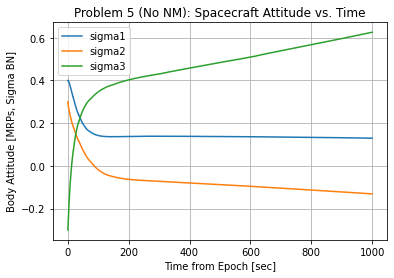

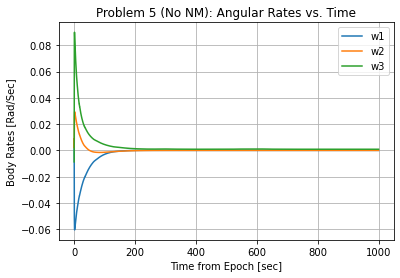

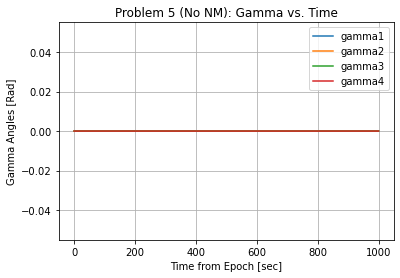

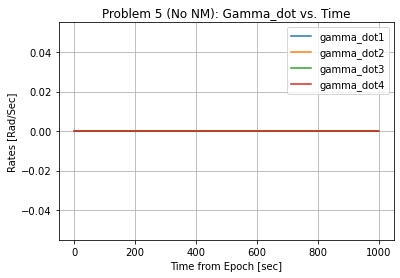

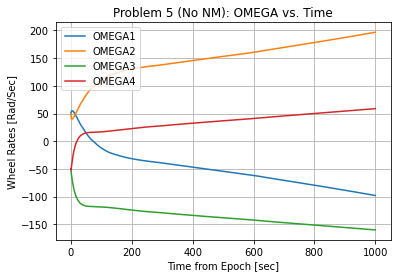

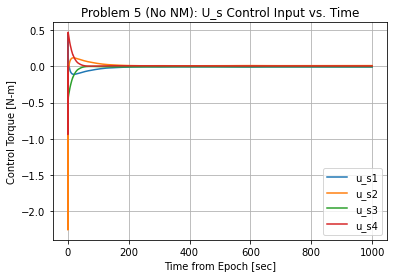

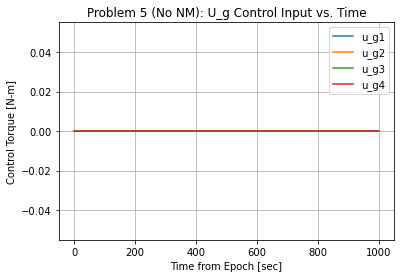

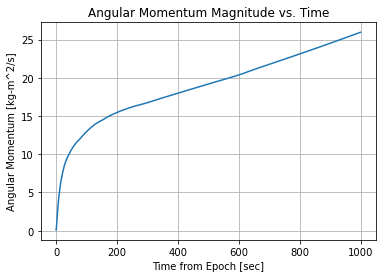

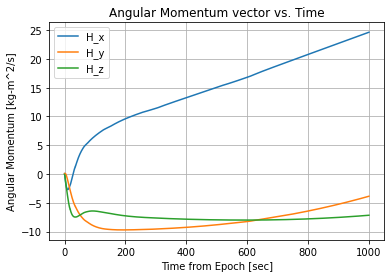

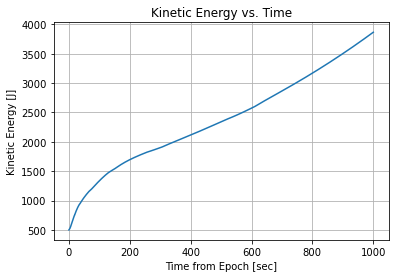

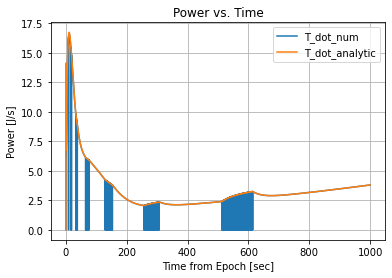

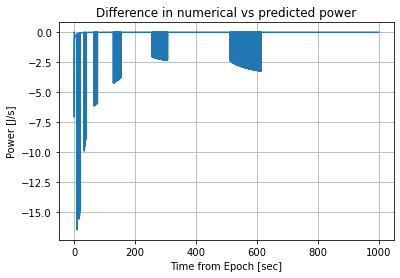

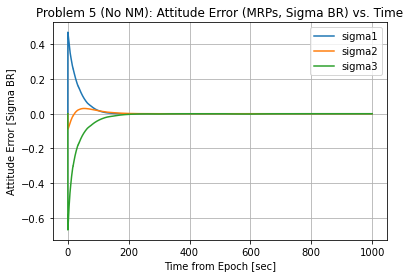

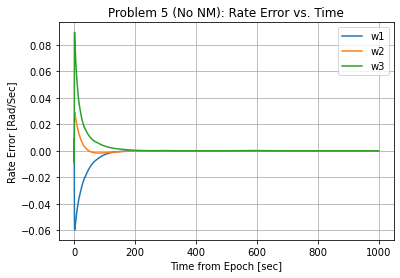

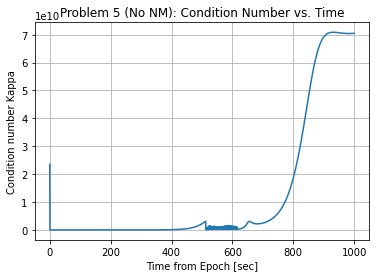

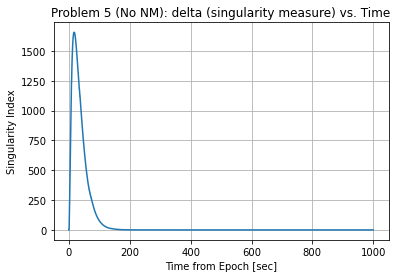

In [33]:
# Run simulation
t = 1000 # Simulation length in seconds
int_time, attitude, rates, gamma, gamma_dot, OMEGA, I_list, G_list, w_gframe, gimbal_frames_list, control, att_err, rate_err, kappa_list, d_singular_list  = integrate(t, control_reference='no_control')
plot_states([int_time, attitude, rates, gamma, gamma_dot, OMEGA, I_list, G_list, w_gframe, gimbal_frames_list, control, att_err, rate_err, kappa_list, d_singular_list], 'Problem 5 (No NM)')
plot_control([int_time, attitude, rates, gamma, gamma_dot, OMEGA, I_list, G_list, w_gframe, gimbal_frames_list, control, att_err, rate_err, kappa_list, d_singular_list], 'Problem 5 (No NM)')
plot_conservation([int_time, attitude, rates, gamma, gamma_dot, OMEGA, I_list, G_list, w_gframe, gimbal_frames_list, control, att_err, rate_err, kappa_list, d_singular_list], 'Problem 5 (No NM)')
plot_errors([int_time, attitude, rates, gamma, gamma_dot, OMEGA, I_list, G_list, w_gframe, gimbal_frames_list, control, att_err, rate_err, kappa_list, d_singular_list], 'Problem 5 (No NM)')
plot_checks([int_time, attitude, rates, gamma, gamma_dot, OMEGA, I_list, G_list, w_gframe, gimbal_frames_list, control, att_err, rate_err, kappa_list, d_singular_list], 'Problem 5 (No NM)')